In [10]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt
import numpy as np

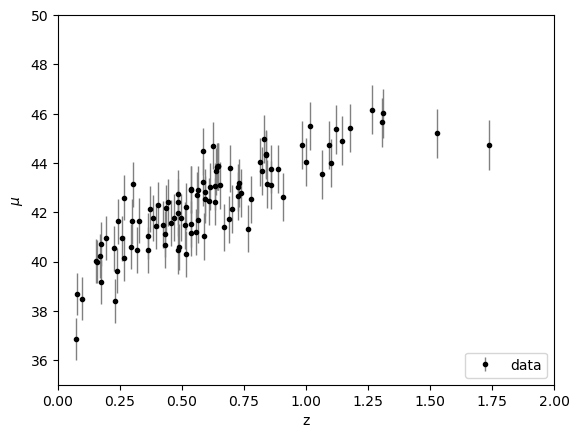

In [11]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [13]:
z = np.linspace(0,2, 100)

kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2) #default kernel is RBF (radial-basis function kernel)
gpr.fit(z_sample[:, None], mu_sample) #fitting gpr to our data
gpr_value, gpr_err = gpr.predict(z[:, None], return_std=True) #and predicting the expectation value and its std

print(gpr.kernel_)

30.7**2 * RBF(length_scale=3.9)


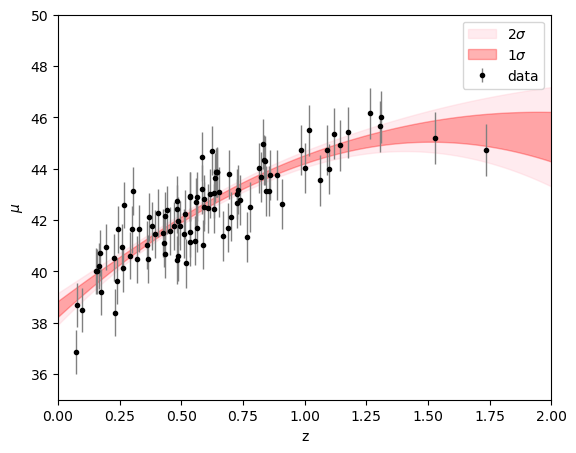

In [14]:
fig = plt.figure(figsize = (14, 5))

ax = fig.add_subplot(121)
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.set(xlabel = 'z', ylabel = '$\mu$', xlim = (0, 2), ylim = (35, 50))
ax.fill_between(z, gpr_value - 2 * gpr_err, gpr_value + 2 * gpr_err,  color='pink', alpha=0.3, label = '2$\sigma$')
ax.fill_between(z, gpr_value - gpr_err, gpr_value +  gpr_err,  color='red', alpha=0.3, label = '1$\sigma$')

plt.legend()
plt.show()

Let's now cross validate the parameters of the kernels.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, ydy_train, ydy_val = train_test_split(z_sample[:, None], np.array([mu_sample,dmu]).T, test_size = 0.3, random_state = 4)

y_train, dy_train = ydy_train.T
y_val, dy_val = ydy_val.T

In [16]:
def error_func(X, y, model):
    return np.sqrt( (1/len(X)) * (np.sum((y - model.predict(X, return_std=False)) ** 2)) )
    
def get_err (model):
    model.fit(X_train, y_train)
    error_train = error_func(X_train, y_train, model)
    error_val = error_func(X_val, y_val, model)
    return error_train, error_val

In [19]:
err_train = []
err_val = []

n_range = np.logspace(-3, 3, 9)
m_range = np.logspace(-2, 2, 5)

for m in m_range:
    kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(m, (m-m/10, m+m/10))
    model = GaussianProcessRegressor(kernel, alpha = dy_train **2)
    a, b = get_err(model)
    print(m, a, b)
    err_train.append(a)
    err_val.append(b)

#plt.plot(m_range, err_train, label = 'training error')
#plt.plot(m_range, err_val, label ='validation error')
#plt.legend()
#plt.show()

0.01 0.2515089541146462 15.828723452554883
0.1 0.7266474674242959 0.9978934360865035
1.0 0.8977576174847408 0.8407178550315462
10.0 0.9798896722766307 0.9109409449863849
100.0 1.2514965288141169 1.1114354383112734


C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 0.011. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 0.11. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\s

Changing the bandwidth alone seems to indicate that a bandwidth between 1 and 10 would be best.

In [21]:
err_train = []
err_val = []

for n in n_range:
    kernel = kernels.ConstantKernel(n, (n - n/10, n+n/10)) * kernels.RBF(10, (1e-2, 1e2))
    model = GaussianProcessRegressor(kernel, alpha = dy_train **2)
    a, b = get_err(model)
    print(n, a, b)
    err_train.append(a)
    err_val.append(b)

C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.0011. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.00618575457709384. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\en

0.001 39.01333108243294 39.21362396865713
0.005623413251903491 28.604480030691885 28.798453799061054
0.03162277660168379 11.60276864803626 11.761297802163204
0.1778279410038923 3.3013568216589912 3.287000023987142
1.0 1.3582835052504703 1.2185347475850434
5.623413251903491 0.9616969290135656 0.8927450578174018
31.622776601683793 0.9252470138403714 0.8721764799905787
177.82794100389228 0.9234774655519788 0.8716429230613806
1000.0 0.9239921802902381 0.871473839690136


C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 34.785054261852174. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 195.6107351042815. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Instead, keeping the bandwidth fixed and changing the normalization indicates that a value larger than 1 could be good. We can now put the two together:

In [39]:
err_train = []
err_val = []

m_range = np.linspace(1, 10, 20)
n_range = np.logspace(0, 3, 20)

for n in n_range:
    for m in m_range:
        kernel = kernels.ConstantKernel(n, (n - n/10, n+n/10)) * kernels.RBF(m, (m-m/10, m+m/10))
        model = GaussianProcessRegressor(kernel, alpha = dy_train **2)
        a, b = get_err(model)
        #print(n, m, a, b)
        err_train.append(a)
        err_val.append(b)
        if min(err_val) == b: n_min, m_min = n, m

C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-

min for n, min for m: 1000.0 1.0
27.6**2 * RBF(length_scale=1.5)


C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


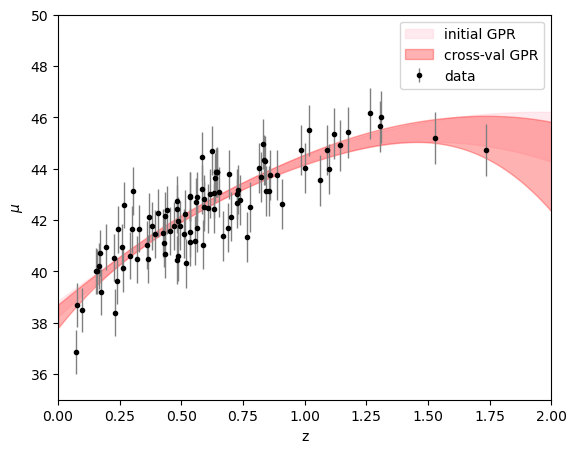

In [41]:
print('min for n, min for m:', n_min, m_min)

z = np.linspace(0,2, 100)

kernel = kernels.ConstantKernel(n_min, (n_min - n_min/2, n_min + n_min/2)) * kernels.RBF(m_min, (m_min-m_min/2, m_min+m_min/2))

gpr_best = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2) #default kernel is RBF (radial-basis function kernel)
gpr_best.fit(z_sample[:, None], mu_sample) #fitting gpr to our data
print(gpr_best.kernel_)
gpr_best_value, gpr_best_err = gpr_best.predict(z[:, None], return_std=True)

fig = plt.figure(figsize = (14, 5))

ax = fig.add_subplot(121)
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.set(xlabel = 'z', ylabel = '$\mu$', xlim = (0, 2), ylim = (35, 50))
ax.fill_between(z, gpr_value - gpr_err, gpr_value + gpr_err,  color='pink', alpha=0.3, label = 'initial GPR')
ax.fill_between(z, gpr_best_value - gpr_best_err, gpr_best_value +  gpr_best_err,  color='red', alpha=0.3, label = 'cross-val GPR')

plt.legend()
plt.show()

They tend to be pretty much in agreement, except for the end, where the division of the data between training and validation could heavily influence the curve.

We now want to fit our data with the predicted relationship between the distance and the redshift:

$$\mu = 5 \log \left( \frac{c/H_0} {10^{-5} {\rm Mpc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

where c is expressed in km/s and $H_0$ is in km/s/Mpc. For a flat universe this becomes:

$$\mu = 5 \log \left( \frac{c/H_0} {10^{-5} {\rm Mpc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)}} \right) $$

meaning we have 2 parameters: $H_0$ and $\Omega_m$. Since we need to do a parametric fit, we're going to need MCMC (and/or Nested Sampling).

In [42]:
import emcee
import scipy.stats
import corner

In [131]:
n_dim = 2
n_walkers = 5
n_steps = int(1e+4)

data = np.array([z_sample, mu_sample, dmu]).T

H_0_min, H_0_max = 50, 100
omega_min, omega_max = 0.1, 1
c = 3e+6

starting_guesses = np.array([50, 0.1]) + 0.1 * np.random.randn(n_walkers, n_dim)
print(starting_guesses.shape)

(5, 2)


We need to define the loglikelihood and the logpriors, which are then combined to generate the logposterior which is used my MCMC. Since w don't know much, we can assume our loglikelihhod to be gaussian and our priors to be flat in a certain range, therefore the logprior is null within the given range and equal to -$\infty$ outside.

In [167]:
#from scipy import integrate
#
#def model(x, h0, omega):
#    constant = ( c * (1+x) ) / ( h0 * 1E-5 )
#    #print(constant)
#    integral = integrate.quad (lambda z: np.sqrt( omega * (1+z**3) + (1-omega) ) ** (-1), 0, x)
#    y_predict = 5.0 * np.log10(constant * integral[0])
#    return y_predict

In [208]:
from astropy.cosmology import LambdaCDM

def model(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

41.779631579629424


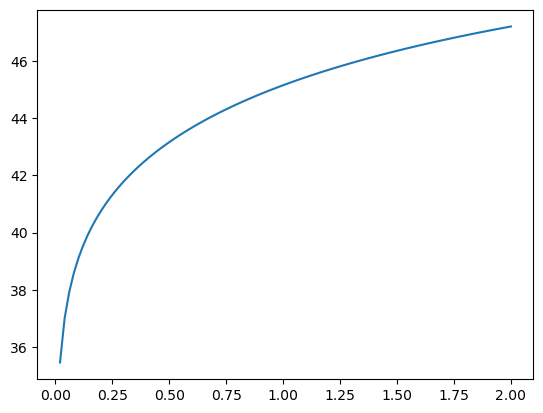

In [175]:
print(model(z_sample[0], 50, 0.1))

plt.plot(z, model(z, 50, 0.1))

In [179]:
def log_llh(par, data):
    H_0, omega_m = par
    if omega_m < 0: return 0.0
    x, y, sigma_y = data.T
    y_predict = model(x, H_0, omega_m)
    result = -0.5 * np.sum( (y-y_predict)**2 / sigma_y**2 ) 
    return result
    
def log_prior(par):
    H_0, omega_m = par
    if H_0_min < H_0 < H_0_max and omega_min < omega_m < omega_max: return 0.0
    else: return -np.inf
        
def log_posterior(par, data):
    lp = log_llh(par, data) + log_prior(par)
    if np.isnan(lp): print(lp, log_llh(par, data), log_prior(par))
    return lp

In [180]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=[data])
sampler.run_mcmc(starting_guesses, n_steps)

print("done")

done


We then take our samples and autocorrelation time, which we use to thin the data

In [181]:
samples = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)

[54.66931624 50.09619493]


In [182]:
samples.shape

(10000, 5, 2)

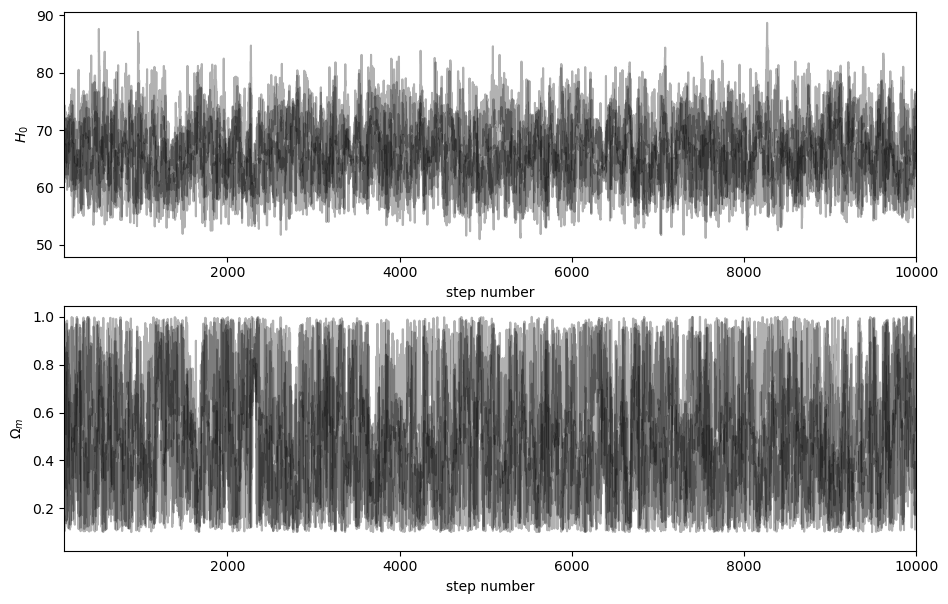

In [187]:
fig = plt.figure(figsize=(11, 7))

ax = fig.add_subplot(211)
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set(ylabel = '$H_0$', xlabel = 'step number', xlim = (100, len(samples)))

ax = fig.add_subplot(212)
ax.plot(samples[:, :, 1], "k", alpha=0.3)
ax.set(ylabel = '$\Omega_m$', xlabel = 'step number', xlim = (100, len(samples)))

plt.show()

We now set the initial burn in as 3 times the autocorrelation time and thin the samples:

In [188]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(910, 2)


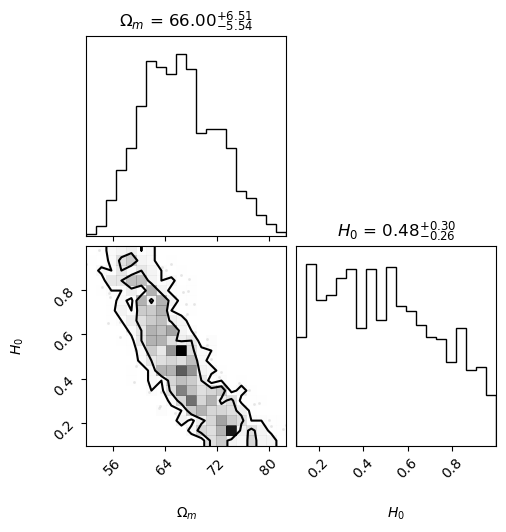

In [189]:
fig = corner.corner(flat_samples, labels=["$\Omega_m$","$H_0$"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71])

(35.0, 50.0)

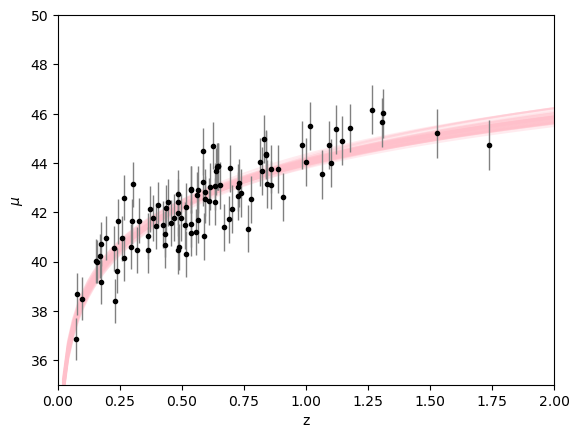

In [196]:
for h, o in flat_samples[:][:50]:
    plt.plot(z, model(z, h, o), color = 'pink', alpha = 0.3)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

## No dark energy model

In [215]:
def log_llh(par, data):
    H_0 = par[0]
    x, y, sigma_y = data.T
    y_predict = model(x, H_0)
    result = -0.5 * np.sum( (y-y_predict)**2 / sigma_y**2 ) 
    return result
    
def log_prior(par):
    H_0 = par[0]
    if H_0_min < H_0 < H_0_max: return 0.0
    else: return -np.inf
        
def log_posterior(par, data):
    lp = log_llh(par, data) + log_prior(par)
    if np.isnan(lp): print(lp, log_llh(par, data), log_prior(par))
    return lp

In [229]:
n_dim = 1
starting_guesses = 50 + 0.1 * np.random.randn(n_walkers, n_dim)

In [230]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=[data])
sampler.run_mcmc(starting_guesses, n_steps)

print("done")

done


We then take our samples and autocorrelation time, which we use to thin the data

In [231]:
samples = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)

[25.66471811]


In [232]:
print(samples[:, :, 0])

[[49.96281286 49.94075257 50.31068587 49.97489141 49.98552347]
 [49.96281286 49.94075257 50.20942107 49.97489141 49.98552347]
 [49.96281286 49.94075257 50.20942107 49.97489141 50.01914281]
 ...
 [54.44584739 59.66764155 60.88581461 56.45059791 58.69176532]
 [54.41606398 59.91711385 60.88581461 56.87399355 59.3394709 ]
 [54.11397917 57.92075455 60.85817811 54.72003618 58.97380946]]


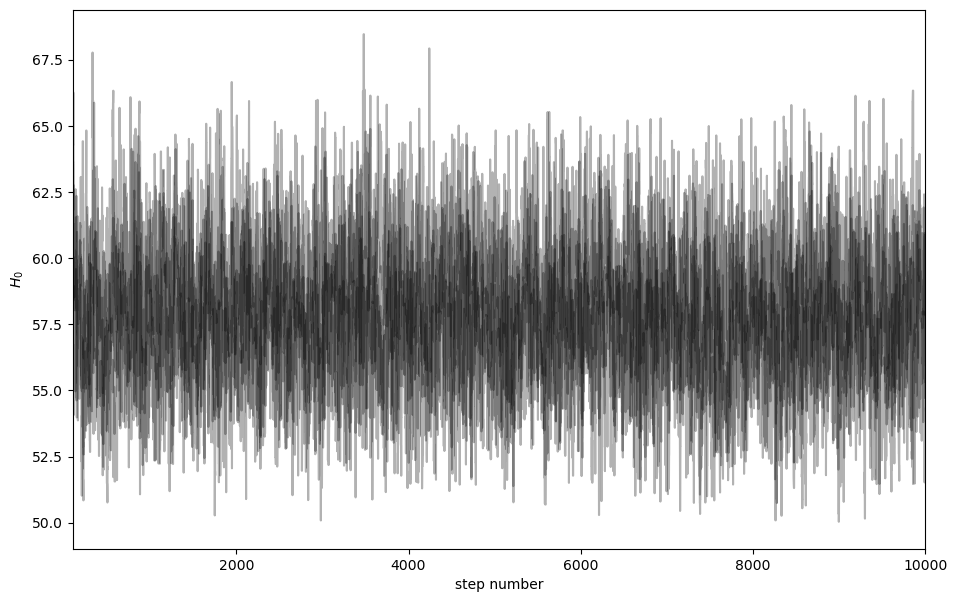

In [233]:
fig = plt.figure(figsize=(11, 7))

ax = fig.add_subplot(111)
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set(ylabel = '$H_0$', xlabel = 'step number', xlim = (100, len(samples)))

plt.show()

In [234]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(1985, 1)


(35.0, 50.0)

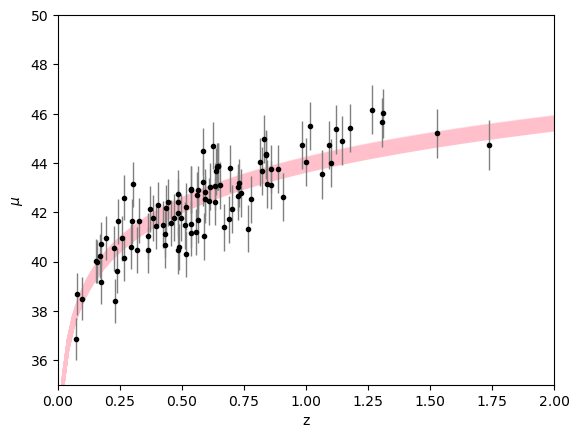

In [254]:
for h in flat_samples[:, 0]:
    plt.plot(z, model(z, h), color = 'pink', alpha = 0.3)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Since it is a model selection problem, I should probably rerun with nested sampling and compute the odds ratio.

## Mock data
Last part! Let's generate mock data from our model.

C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\astropy\cosmology\flrw\base.py:1352: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


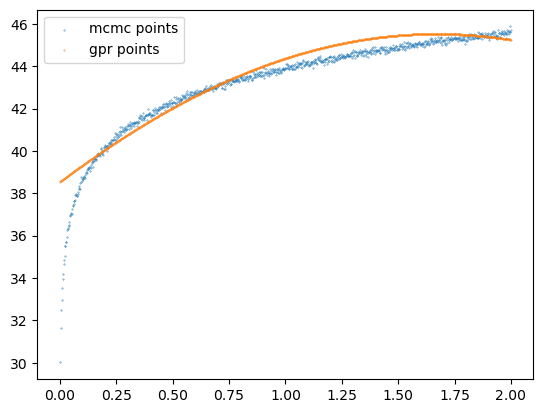

In [275]:
z = np.linspace(0, 2, 1000)
mu_mc = []
mu_gpr = []
for zi in z:
    gen_samples = np.array([np.random.choice(flat_samples[:, 0]), 1])
    mu_mc.append(model(zi, gen_samples[0], gen_samples[1]))
    mu_gpr.append(gpr.predict([[zi]], return_std=False))

plt.scatter(z, mu_mc, s = 0.1, label = 'mcmc points')
plt.scatter(z, mu_gpr, s=0.1, label = 'gpr points')
plt.legend()
plt.show()